# Kidney Dataset

Below, we replicate the scRNA-seq analysis and do pathway state analysis on the E18.5 day mouse kidney 10X scRNA-seq dataset published by [Combes et al.](https://dev.biologists.org/content/146/12/dev178673) in their paper __"Single cell analysis of the developing mouse kidney provides deeper insight into marker gene expression and ligand-receptor crosstalk"__ 

The dataset sequences three pairs of kidneys at day E18.5.

We use the Scanpy Python package for analyzing the scRNA-seq data, and we use the Slingshot package to conduct pseudotime analysis. The main steps of our data analysis are quality-control, normalization, global clustering, pseudotime analysis, and pathway state analysis.

## Table of Contents:
* ### [Data Pre-Processing](#1-bullet)
 * #### [Data Before Processing](#2-bullet)
 * #### [Data Normalization](#3-bullet)
 * #### [Highly-Variable Gene Selection](#4-bullet)
 
* ### [Data Visualization](#5-bullet)
 * #### [Principal Component Analysis](#6-bullet)
 * #### [Computing the Neighborhood Graph and UMAPs](#7-bullet)
 * #### [Clustering](#8-bullet)
 
* ### [Nephrons](#9-bullet)
 * #### [Data Visualization](#10-bullet)
 * #### [Cell Type Assignment](#11-bullet)
 * #### [Pseudotime Trajectory Analysis](#12-bullet)
 * #### [Pathway States Analysis](#13-bullet)
    * #### [Differential Gene Expression Test](#14-bullet)

In [1]:
import warnings # ignores annoying warnings that pop up during import of packags
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import scipy as sp
import pandas as pd
import seaborn as sb
from gprofiler import GProfiler

import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.font_manager
matplotlib.rcParams['font.family'] = "calibri"
from matplotlib.figure import Figure
from matplotlib.backend_bases import FigureCanvasBase

import module as md  # a module I wrote for the analysis

import panel as pn
pn.extension()

import glob

from rpy2.robjects import pandas2ri
import anndata2ri
import rpy2.rinterface_lib.callbacks

In [2]:
# We're going to change some of the parameters for warning/error messages in several packages. 
import logging

# This ignores an annoying matplotlib error that comes up with the colors on a plot.
matplotlib_axes_logger.setLevel('ERROR')

# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Set Scanpy's verbose output
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()   # print package settings for Scanpy (replicability)
sc.settings.set_figure_params(dpi=80)

# Set directories for the data, results, and figures. SPECIFY AS APPROPRIATE
resdir = './e18.5_kidney/results/'
datadir= './e18.5_kidney/data/'

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.7.1 leidenalg==0.7.0


In [3]:
%%R
library(scran) # single cell RNA-seq analysis
library(RColorBrewer) # colors for plots
library(slingshot) # Slingshot for pseudotime analysis
library(gam)
library(clusterExperiment)
library(ggplot2) # plotting package
library(plyr) # plotting package
library(scales)
library(DEsingle)

## Data Pre-Processing <a class="anchor" id="1-bullet"></a>

In [4]:
# We create the AnnData object by uploading the gene expression matrix.
file = datadir+'kidney_csv_matrix.csv' # file that stores the data, a csv for this paper
adata = sc.read_csv(file).T

adata

AnnData object with n_obs × n_vars = 5639 × 16502

In [5]:
# We want to add metadata annotations to the data.
# The paper defines annotations for batches, cell-cycle, 
# a broad category (i.e. where in the kidney) and a specific
# cell type. 
metadata = datadir+'kidney_csv_meta.csv'
df = pd.read_csv(metadata)

for index, row in df.iterrows():
    if row['Unnamed: 0'] not in adata.obs.index:
        df.drop(index, inplace=True)
adata.obs['cell_cycle'] = list(df['cell_cycle'])
adata.obs['batch'] = list(df['biorep'])
adata.obs['cell_type'] = list(df['cell_type_final'])
adata.obs['broad_cat'] = list(df['broad_cat'])
adata.obs.head()

cell_cycle batch                      cell_type  \
AAACCTGAGACCCACC-1         G1  kid1               medullary_stroma   
AAACGGGCACATGGGA-1         G1  kid1               medullary_stroma   
AAACGGGTCCTTGACC-1         G1  kid1                cortical_stroma   
AAAGATGAGGCAGGTT-1         G1  kid1  ureteric_epithelium_tip_trunk   
AAAGATGAGTAGCGGT-1         G1  kid1             nephron_progenitor   

                                        broad_cat  
AAACCTGAGACCCACC-1                         stroma  
AAACGGGCACATGGGA-1                         stroma  
AAACGGGTCCTTGACC-1                         stroma  
AAAGATGAGGCAGGTT-1  ureteric_epithelium_tip_trunk  
AAAGATGAGTAGCGGT-1                        nephron

### Data Before Processing <a class="anchor" id="2-bullet"></a>

normalizing counts per cell
    finished (0:00:00)


... storing 'cell_cycle' as categorical
... storing 'batch' as categorical
... storing 'cell_type' as categorical
... storing 'broad_cat' as categorical
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


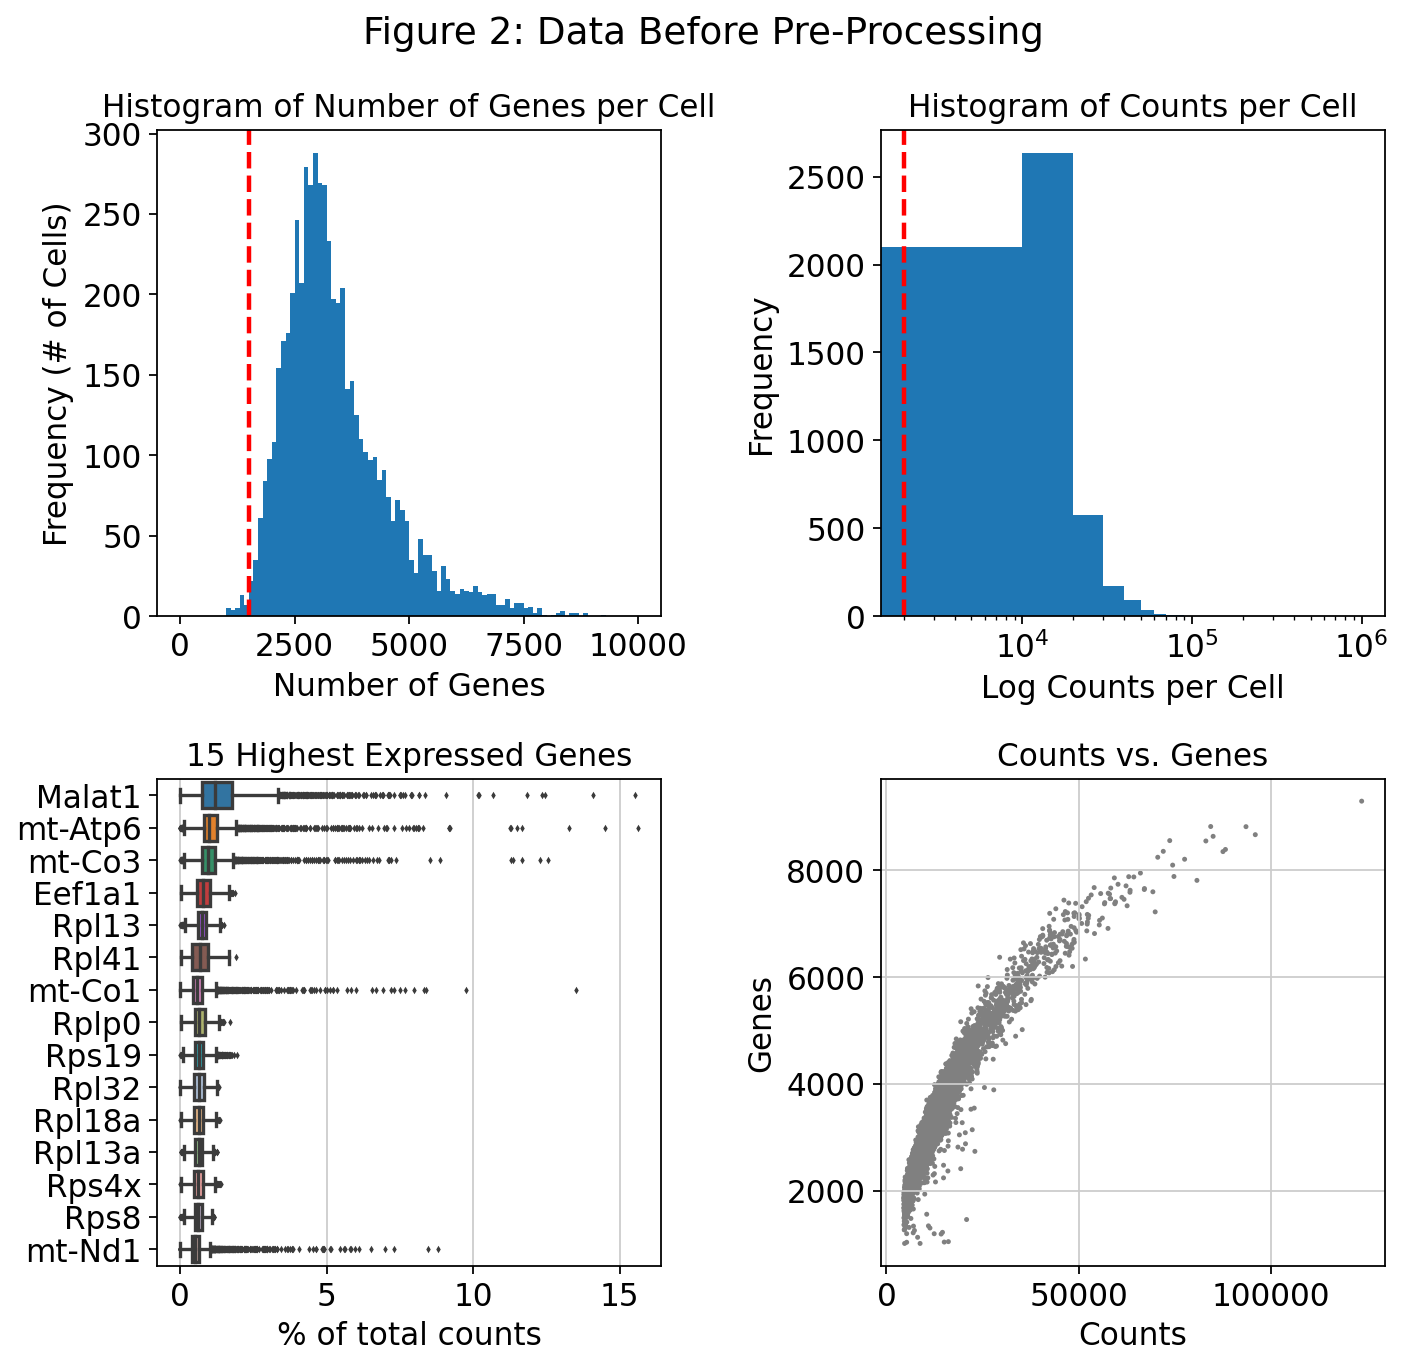

In [6]:
# Below, we display cells with genes/cell and counts/cell, for genes that 
# have at least one 1 count in any cell. 
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

# Set annotations to the AnnData object for total counts, cells per gene
X = np.matrix(adata.X)
adata.obs['n_total_counts_per_cell'] = (X.sum(axis=1).A1)
adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1
adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1

# This line of code makes a plot with the different plots on the data
# prior to processing it. 
pre_processed = md.vis_pre_processing(adata, genes_range=(0, 10000),
    counts_range=(0, 1e6),title='Figure 2: Data Before Pre-Processing',
                                     genes_threshold=1500, counts_threshold=2000)

In [7]:
avg_genes = np.average(adata.obs['n_genes_per_cell'])
avg_counts = np.average(adata.obs['n_total_counts_per_cell'])

print('The average number of genes per cell is ' + str(int(avg_genes)) 
      + ' and the average number of counts per cell is ' 
      + str(int(avg_counts)))

The average number of genes per cell is 3391 and the average number of counts per cell is 14082


The plots above allow us to visualize parameters for our data set, including the number of unique cells and genes captured in the data set, and the distributions of the total number of counts per cell, the total numbers of genes per cell, and the total number of cells per gene. These will allow us to determine our parameters for filtering our data set so we can retain only cells and genes desired.

Below, we adjust the parameters for filtering our cells (based on minimum total counts and the minimum number of genes per cell) and our genes (based on the minimum number of cells the gene is detected in). A high-quality data set for cells has an average of 2,000 counts per cell and  1,000-2,000 genes per cell. We can filter genes as some fraction of the total cell count.

filtered out 34 cells that have less than 1500 genes expressed
filtered out 3 genes that are detected in less than 3 cells


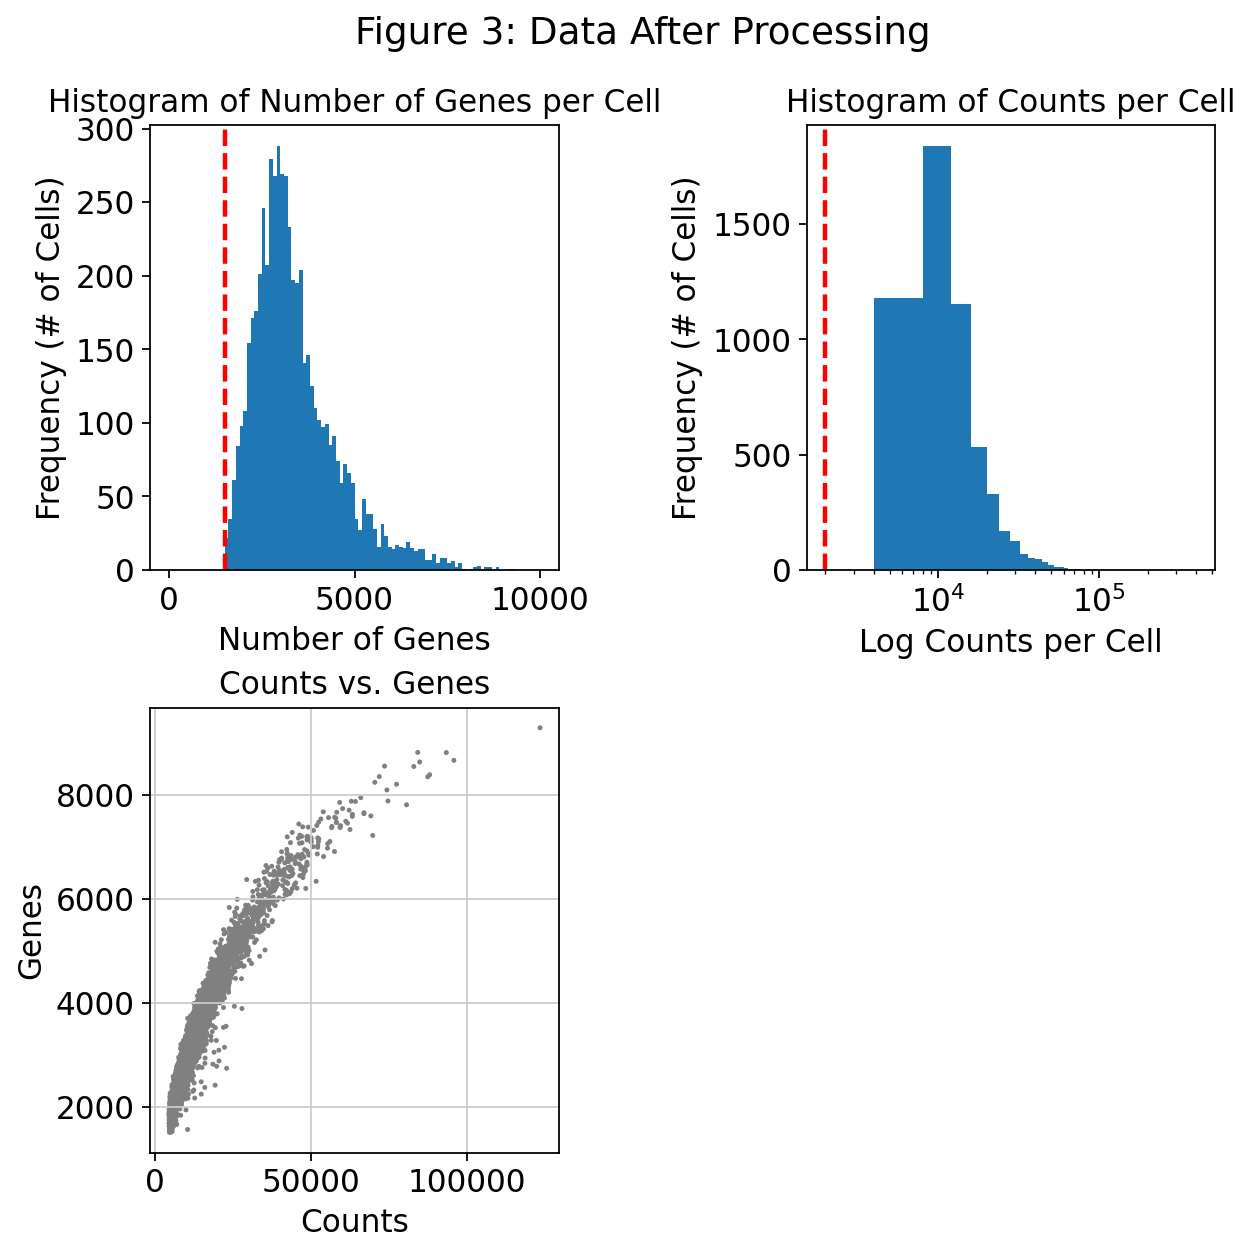

In [8]:
adata = md.filter_data(adata, min_counts=2000, min_genes=1500, min_cells=3)
post_processing = md.vis_post_processing(adata, genes_range=(0, 10000), counts_range=(0, 400000),
                                         title='Figure 3: Data After Processing',
                                        genes_threshold=1500, counts_threshold=2000)

### Data Normalization <a class="anchor" id="3-bullet"></a>

Below, we select cells with genes/cell below a certain value. We should note that transcript counts differ between cells, so a comparison of gene expression using total counts would be biased toward cells with higher total counts. To appropriately compare gene expression, we normalize the count data by scaling it based on total counts. For downstream analysis, we normalize the data using a log(x+1) transformation on the number of counts per cell. 

Yet, Combes et al. use a log (x/10 + 1) normalization in their paper, so that is what we apply here.

In [9]:
adata = adata[adata.obs.n_genes < 9000, :] # filter out cells with genes below 9k/cell to filter out the outlier cell
pre_norm = adata.copy() # keep a version of the count matrix prior to normalization, for DGE testing
adata=md.normalize_data(adata, 1e5) # the max counts are 1e6, so divide by 10 as in the paper

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### Highly-Variable Gene Selection <a class="anchor" id="4-bullet"></a>

Below, we select for genes of interest: Bmp, Wnt, and Notch pathway genes, and marker genes specified in the paper. Note that these genes we select pass our quality-control filters above. Since these genes may not necessarily be highly-variable, we "force" our gene expression matrix to keep our genes of interest for our downstream analysis.

Next, we regress our data on the total number of counts per cell. We then scale our data set by centering each gene's expression with zero mean and unit variance. 

In [10]:
wnt_ligands = md.get_genes(adata, md.wnts)
wnt_receptors = md.get_genes(adata, md.wntr)
bmp_ligands = md.get_genes(adata, md.bmps)
bmp_receptors = md.get_genes(adata, md.bmpr)
notch = md.get_genes(adata, md.notch)

# Get this from the paper!
markers = ['Six2', 'Cited1', 'Crym', 'Wnt4', 'Fam132a', 'Bmper', 'Tmem100', 'Sfrp2', 'Bmp2', 'Mafb',
          'Podxl', 'Nphs1', 'S100g', 'Slc12a1', 'Ace', 'Fbp1', 'Spp2', 'Ret', 'Slco4c1', 'Upk3a',
          'Pdgfra', 'Col3a1', 'Wnt11', 'Dlk1', 'Foxd1', 'Tcf21', 'Dcn', 'Cd34', 'Clec3b', 'Lyz2', 
          'Fcer1g', 'Tyrobp', 'Pecam1', 'Cdh5', 'Flt1',
          "Malat1", "Gapdh"]

pathways = {'Wnt Ligands': wnt_ligands, 'Wnt Receptors': wnt_receptors, 'BMP Ligands': bmp_ligands,
           'BMP Receptors': bmp_receptors, 'Notch': notch}

all_genes = [wnt_ligands, wnt_receptors, bmp_ligands, bmp_receptors, notch, markers]

adata=md.merge_genes(adata, all_genes)
adata=md.scale_data(adata)

regressing out ['n_total_counts_per_cell']
    finished (0:00:26)


In [11]:
adata

AnnData object with n_obs × n_vars = 5604 × 2493
    obs: 'cell_cycle', 'batch', 'cell_type', 'broad_cat', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'

## Data Visualization <a class="anchor" id="5-bullet"></a>

### Principal component analysis <a class="anchor" id="6-bullet"></a>

We perform principal component analysis on the processed data set. This transforms the data to a new linear space and defines a "best-fitting line" for multi-dimensional data. Below, we also plot the variance ratio of the principal components to determine the minimum number of principal components we must select for dimensionality reduction.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


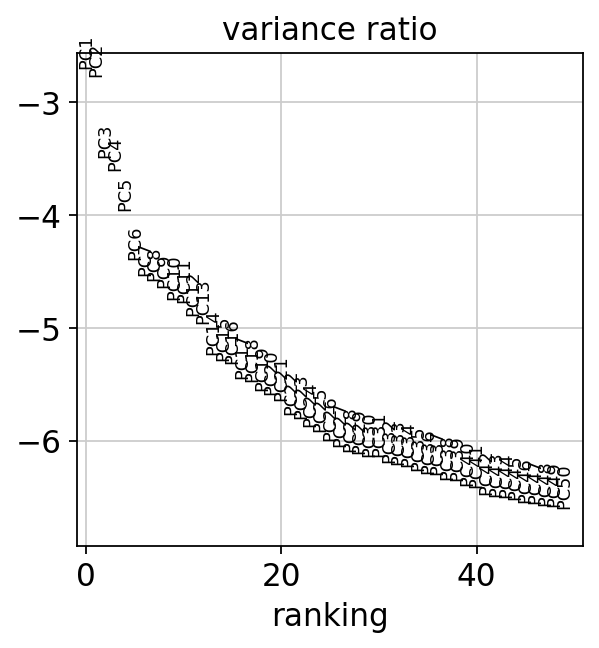

In [12]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

### Computing the Neighborhood Graph and UMAPs <a class="anchor" id="7-bullet"></a>

We can compute a neighborhood graph of cells using a PCA representation of our data matrix. We can then use UMAPs or the Force Atlas algorithm for dimensionality reduction and visualization. We can appropriately adjust the number of principal components we select based on the above variance ratio plot.

In [13]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


### Clustering <a class="anchor" id="8-bullet"></a>

We then want to group the cells based on similarity of gene expression. These smaller clusters can inform us of the heterogeneity within the cell types they make up.

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


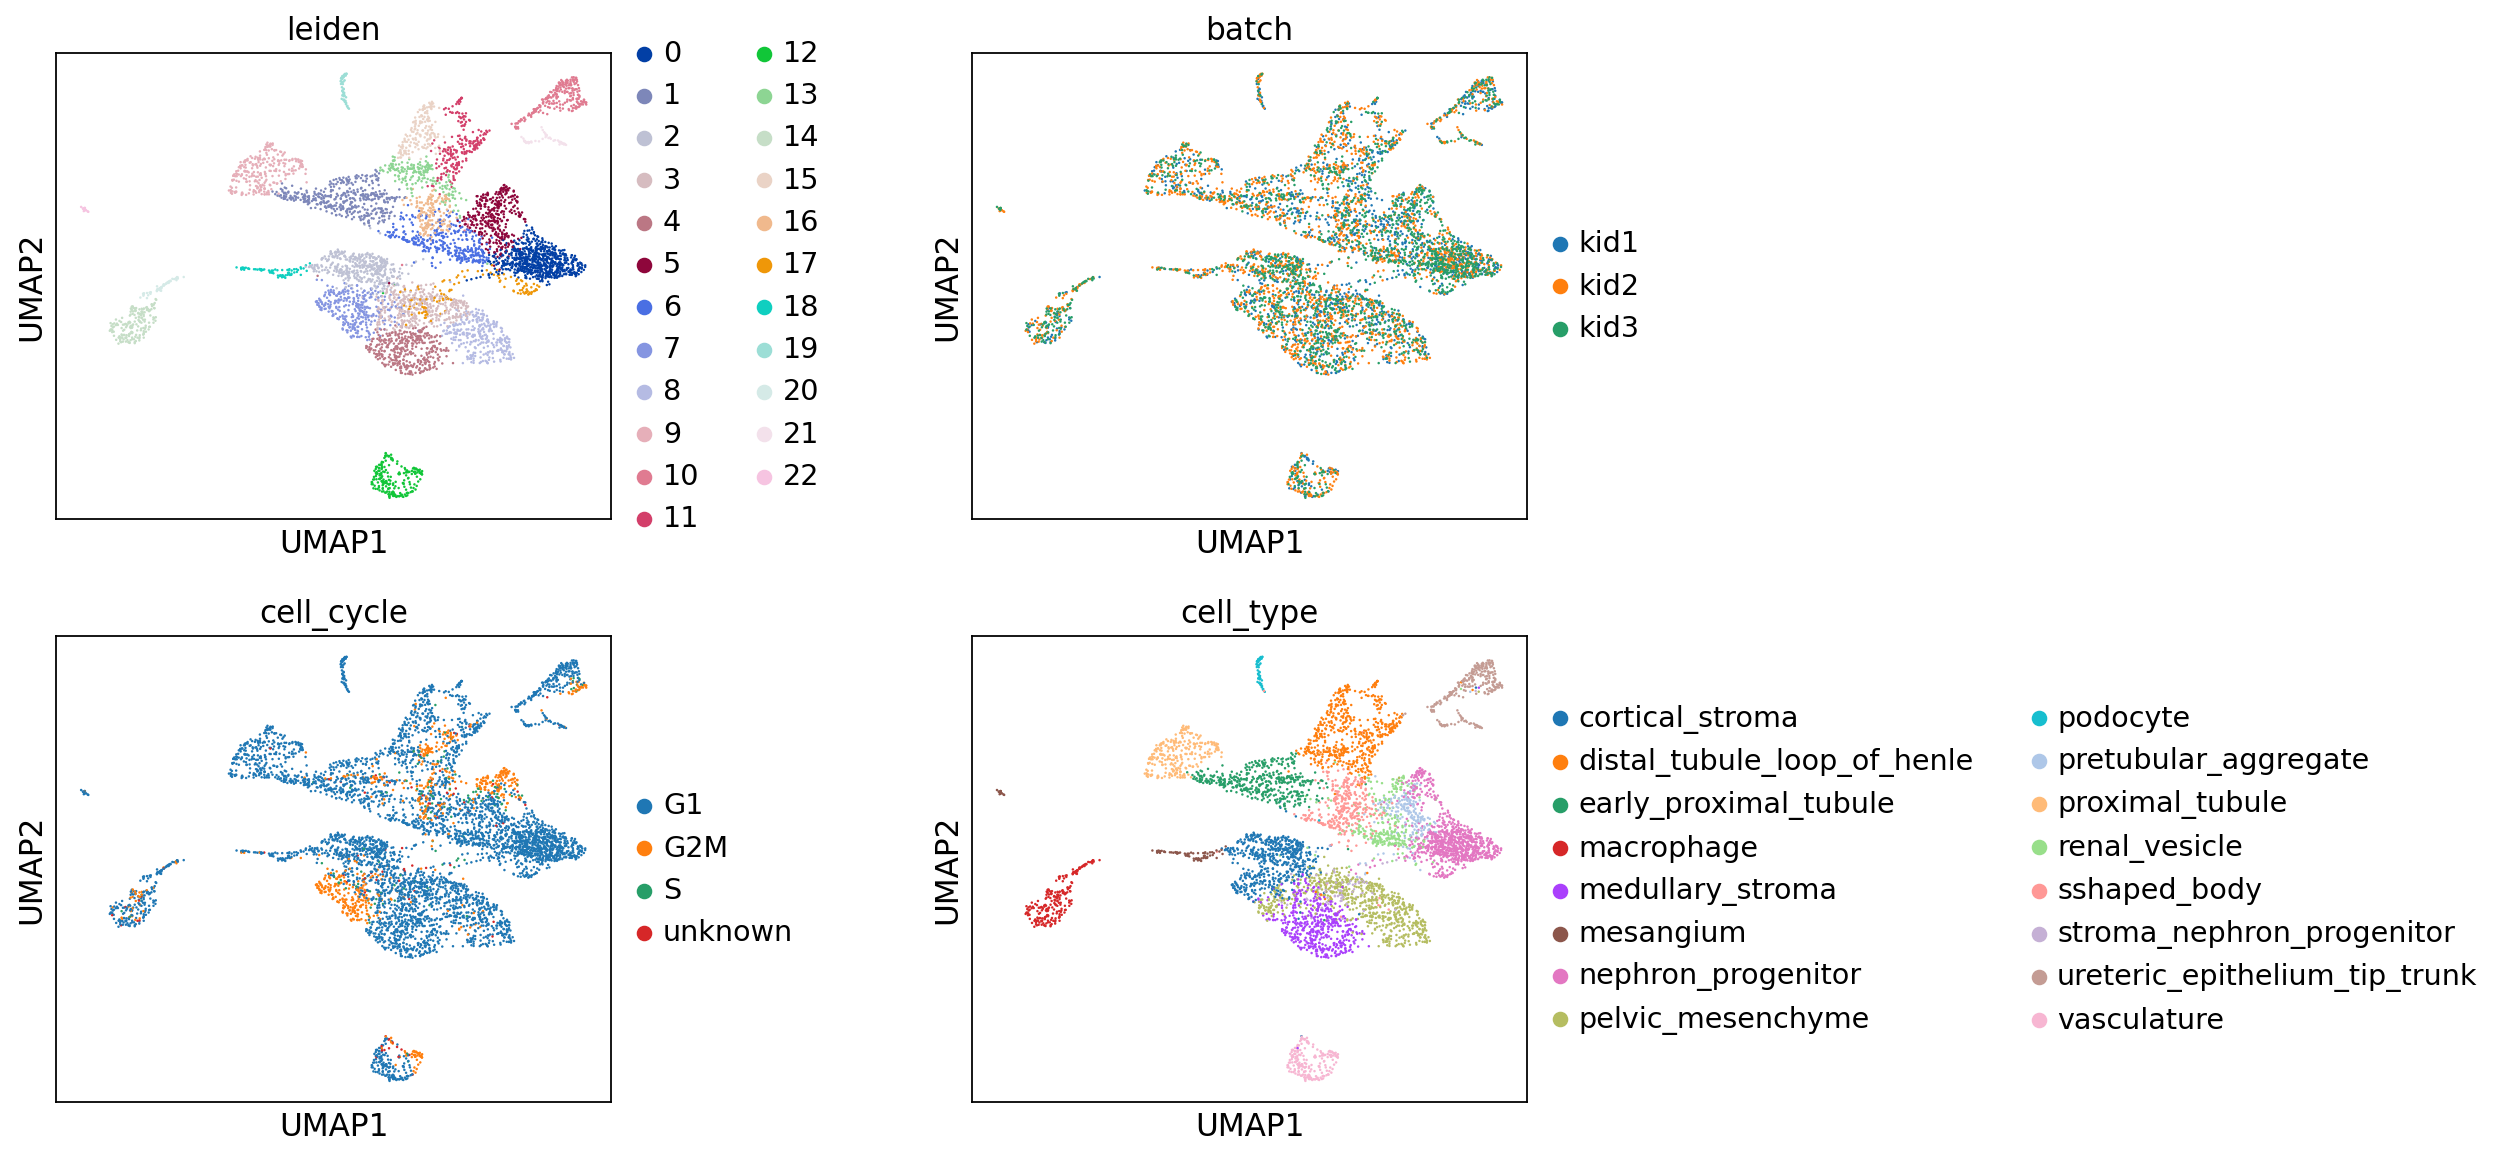

In [14]:
sc.tl.leiden(adata)

sc.pl.umap(adata, color=['leiden', 'batch', 'cell_cycle', 'cell_type'],size=5, ncols=2, wspace=0.5)

... storing 'paper_kid_labels' as categorical
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


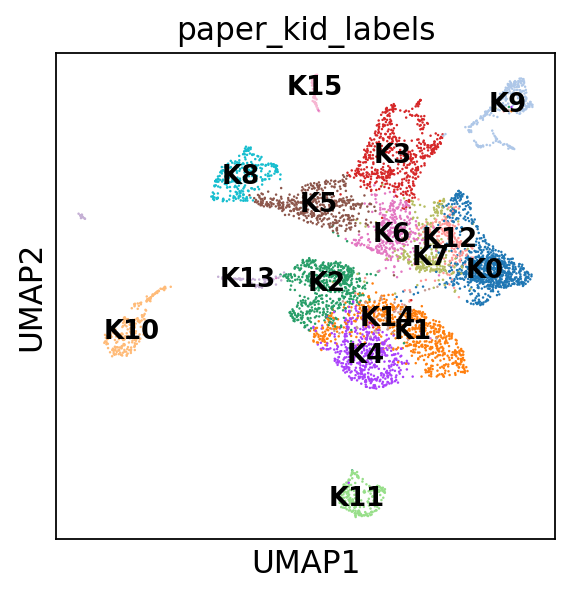

In [15]:
cell_type_to_fig_labels = {'cortical_stroma': 'K2',
        'distal_tubule_loop_of_henle': 'K3',
        'early_proximal_tubule': 'K5',
        'macrophage': 'K10',
        'medullary_stroma': 'K4',
        'mesangium': 'K13',
        'nephron_progenitor': 'K0',
        'pelvic_mesenchyme': 'K1',
        'podocyte': 'K15',
        'pretubular_aggregate': 'K12',
        'proximal_tubule': 'K8',
        'renal_vesicle': 'K7',
        'sshaped_body': 'K6',
        'stroma_nephron_progenitor': 'K14',
        'ureteric_epithelium_tip_trunk': 'K9',
        'vasculature': 'K11'
}

adata.obs['paper_kid_labels'] = adata.obs['cell_type'].replace(cell_type_to_fig_labels)

sc.pl.umap(adata, color=['paper_kid_labels'], size=5, legend_loc='on data', 
           legend_fontweight='bold', legend_fontsize='small')

## Nephrons <a class="anchor" id="9-bullet"></a>

Combes et al. selects cell types labeled as nephrons and reclusters them and computes pseudotime trajectories on the nephron subset. We do the same below: we recompute PCA, nearest neighbors, and UMAPs on this nephron subset.

In [16]:
# Make a separate AnnData object for the nephron cells (as labeled by clusters in the paper)
nephron_adata = adata[adata.obs['paper_kid_labels'].isin(['K15','K8','K5','K6','K7','K12','K3','K0'])]

nephron_adata

View of AnnData object with n_obs × n_vars = 2979 × 2493
    obs: 'cell_cycle', 'batch', 'cell_type', 'broad_cat', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts', 'leiden', 'paper_kid_labels'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'batch_colors', 'cell_cycle_colors', 'cell_type_colors', 'paper_kid_labels_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Data Visualization <a class="anchor" id="10-bullet"></a>

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


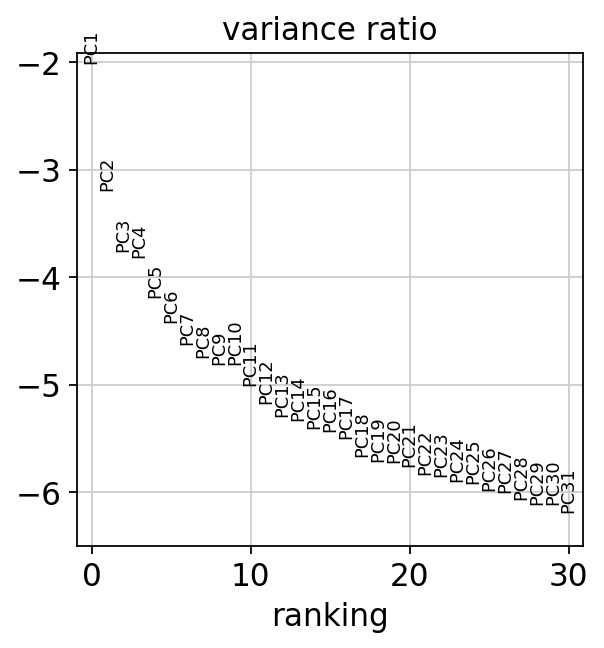

In [17]:
sc.tl.pca(nephron_adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(nephron_adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


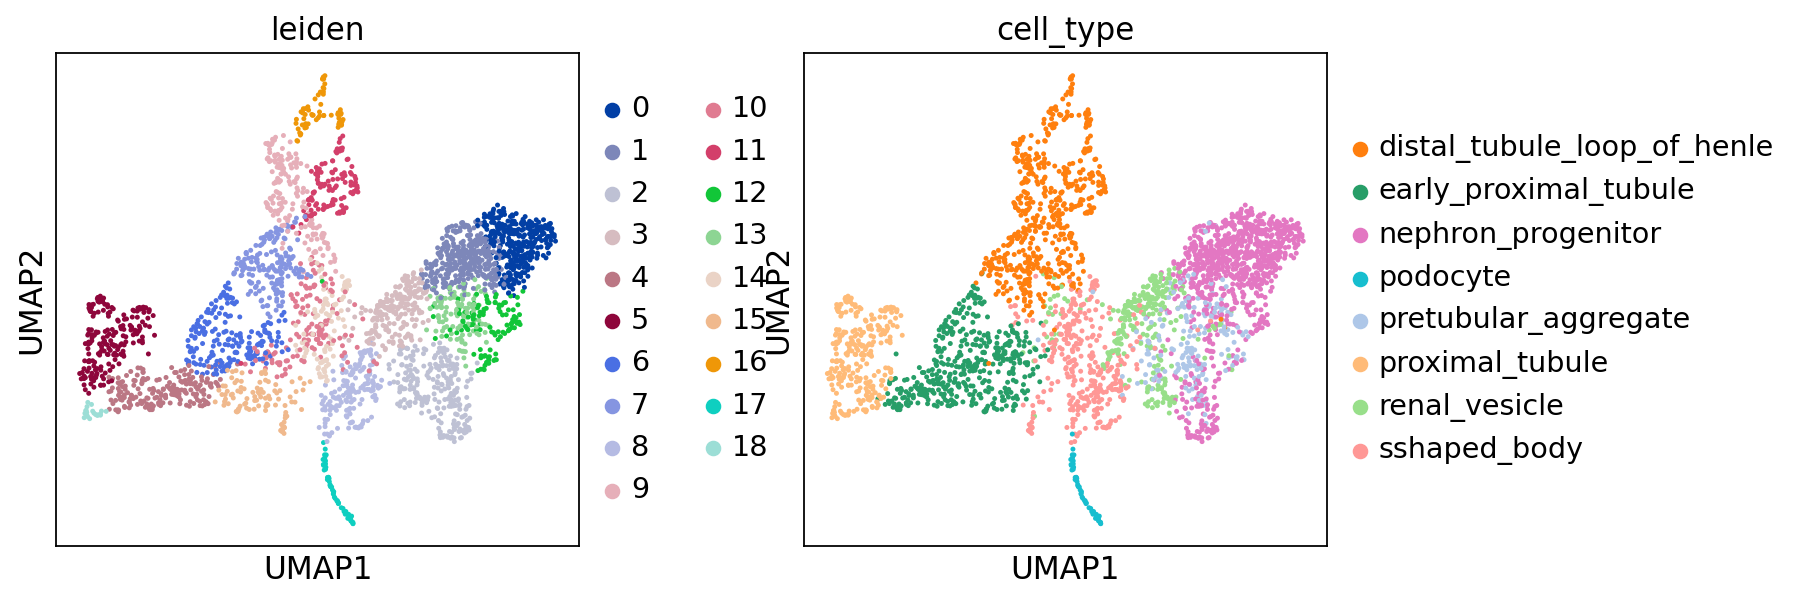

In [18]:
sc.pp.neighbors(nephron_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(nephron_adata)

sc.tl.leiden(nephron_adata)
sc.pl.umap(nephron_adata, color= ['leiden', 'cell_type'], 
          size = 20, wspace=0.3)

The podocytes trajectory obtained by Combes et al. conflicts with previously published cell fate analysis for nephrons. As we do not currently know the appropriate trajectory order for podocytes, we will discard them from our analysis and recompute the UMAPs.

In [19]:
# Remove Podocytes, whose trajectory is not agreed upon.
nephron_adata = nephron_adata[~nephron_adata.obs['cell_type'].isin(['podocyte'])]
nephron_adata

View of AnnData object with n_obs × n_vars = 2925 × 2493
    obs: 'cell_cycle', 'batch', 'cell_type', 'broad_cat', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_counts', 'leiden', 'paper_kid_labels'
    var: 'n_cells', 'n_cells_per_gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'batch_colors', 'cell_cycle_colors', 'cell_type_colors', 'paper_kid_labels_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


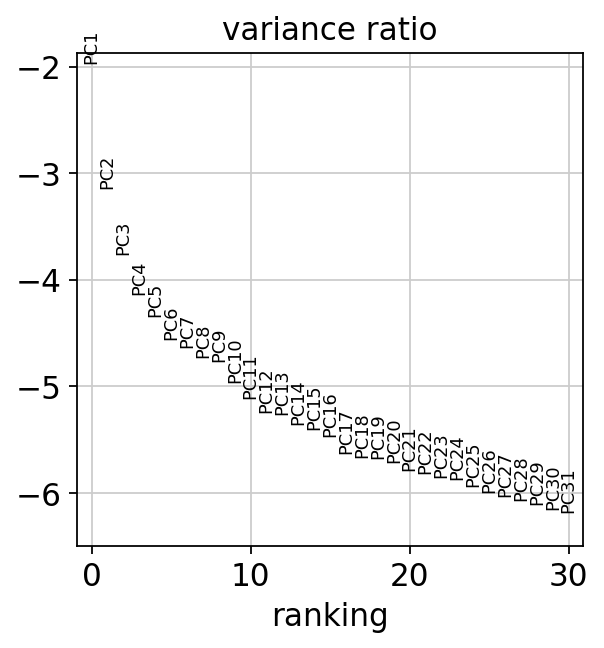

In [20]:
sc.tl.pca(nephron_adata, svd_solver='arpack')

sc.pl.pca_variance_ratio(nephron_adata, log=True)

In [21]:
sc.pp.neighbors(nephron_adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(nephron_adata, n_components=3)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


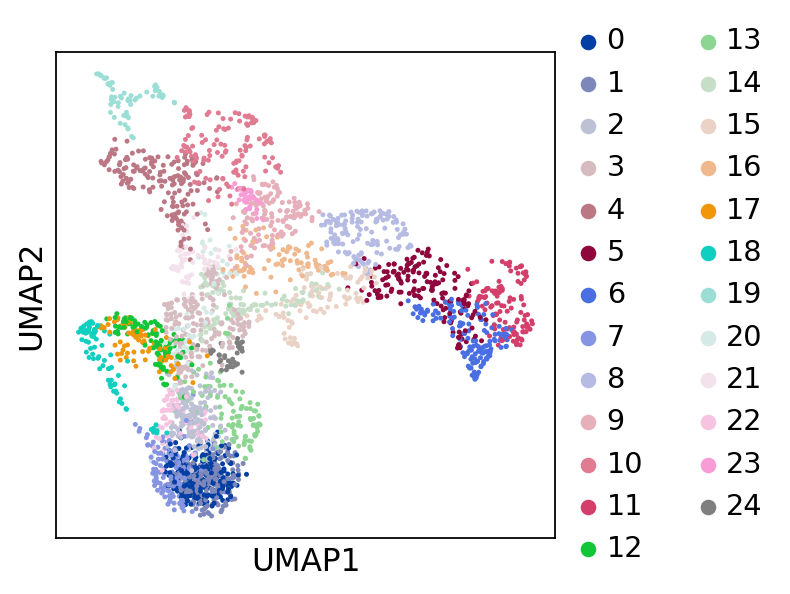

In [22]:
sc.tl.leiden(nephron_adata, resolution=1.5)
sc.pl.umap(nephron_adata, color='leiden', size=20, save='_leiden.png', title='')

### Cell Type Assignment <a class="anchor" id="11-bullet"></a>

In their paper, Combes et al. do not give cell type annotations for nephrons. Yet, they do give gene markers for the cell type clusters they identify in the nephron subset. We can map these cell types onto our Leiden cluster based on average expression of cell type marker genes in each Leiden cluster.

In [23]:
# dictionary that maps marker genes of each cell type in the paper
marker_genes = {
    'N0: NP': ['Tgfbi', 'Cited1', 'Igfbp7', 'Fxyd6', 'Crym', 'Meox1', 'Mest', 'Traf1', 'Six2', 'Cped1',
             'Tril','Tpm2','Robo2','Eya1','Gas1','Il33','Spock2','Meis2','Mfap4','Atp1b1'],
    'N9: NP CC2':['Six2','Tgfbi', 'Cited1','Tril','Meox1','Cped1','Spock2','Meis2','Clmp','Eya1',
              'Psrc1','Mest','Crym','Igfbp7','Tpm2','Gas1','Elavl4','Cenpa','Fxyd6','Cenpe'],
    'N7: NP CC1': ['Six2','Eya1','Tril','Pclaf','Cited1','Spock2','Cped1','Igfbp7','Dtl','Fxyd6',
               'Uhrf1','Lig1','Crym','Atad2','Meis2','Elavl4','Meox2','Itga8','Clmp','Siglecg'],
    'N6: NP': ['Actb','Notch2','Spry2','Cited1','Cbx3','Crym','Meox1','Ppp1r16b','Traf1','Slc39a1',
               'Tgfbi','Supt16','Kdm6b','Zfp691','Rpgrip1','Cped1','Elavl4','Hsf2','Kazald1','Abhd2'],
    'N10: NP-STR': ['Mfap4','Lgals1','Meis2','Tpm2','Mfap2','Hmcn1','Col3a1','Tmsb4x','Cdh11',
                    'Ifitm3','Plac8','Cald1','Zeb2','Bgn','Serpine2','Cnn2','Gucy1a3','Tcf21','Tril','Myl9'],
    'N4: PTA': ['Fam132a','Bmper','Col9a1','Igfbp7','Tmem100','Mycn','Atp1b1','Spint2','Kazald1',
                'Wnt4','Eya1','A730017C20Rik','Gxylt2','Igfbp5','Alas2','Frzb','Fam107a','Lsp1',
                'Clmp','Chchd10'],
    'N3: RV/SSB': ['Lhx1','Lhx1os','Sfrp2','Ccnd1','Cldn5','Clec18a','Npy','Clu','Sox11','Emid1',
                   'Hey1','Osr2','Pdzd2','Eva1a','Lama4','Tm6sf1','Hs3st3b1','Wnt4','Pax8','Lef1'],
    'N8: SSB (D)': ['Gata3','Wfdc2','Wfdc15b','Mecom','Emx2','S100g','Tmem52b','Mal','Epcam',
                    'Tfap2b','Aqp2','Cxcl14','Cldn7','Cldn8','Aqp3','Chst8','E330013P04Rik',
                    'Aldh1a3','Fstl1','Cldn6'],
    'N12: CnS': ['S100g','Tmem213','Atp1b1','Rhbg','Mal','Wfdc2','Rhcg','Tfcp2l1','Cldn8',
                 'Scnn1b','Aqp3','Atp6v1b1','Pgam2','Cystm1','Tmem52b','Aqp2','Spp1','Scnn1g',
                 'Clcnkb','Wfdc15b'],
    'N2: DT/LoH': ['Atp1b1','Tfap2b','Sostdc1','Mal','Epcam','Mecom','Ly6a','Wfdc15b','Cldn19',
                   'Tmem213','Pantr1','Paqr5','Cdh1','Cldn10','Tmem52b','Atp1a1','Slc12a1','Tfcp2l1',
                   'Wfdc2','Fstl1'],
    'N1: EPT': ['Sult1d1','Hdc','Aldob','Pdzk1','Calml4','Slc34a1','Spink1','Fut9','Keg1','Osr2',
                'Slc39a5','Cpn1','Amn','Folr1','Hnf4a','Cyp4a31','Serpina1a','Ttc36','Lrp2','Mep1a'],
    'N5: PT': ['Aldob','Kap','Spp2','Fbp1','Slc34a1','Gatm','Ttc36','Gsta2','Ass1','Sult1d1',
               'Napsa','Pdzk1','Fxyd2','Lrp2','Nat8f1','Miox','Gpx3','Spink1','Aadat','Tmem27']
}

# this function gives a df with a cell type score for each Leiden cluster
cell_type_df = md.evaluate_partition(nephron_adata, marker_genes) 

... storing 'paper_nephron_labels' as categorical


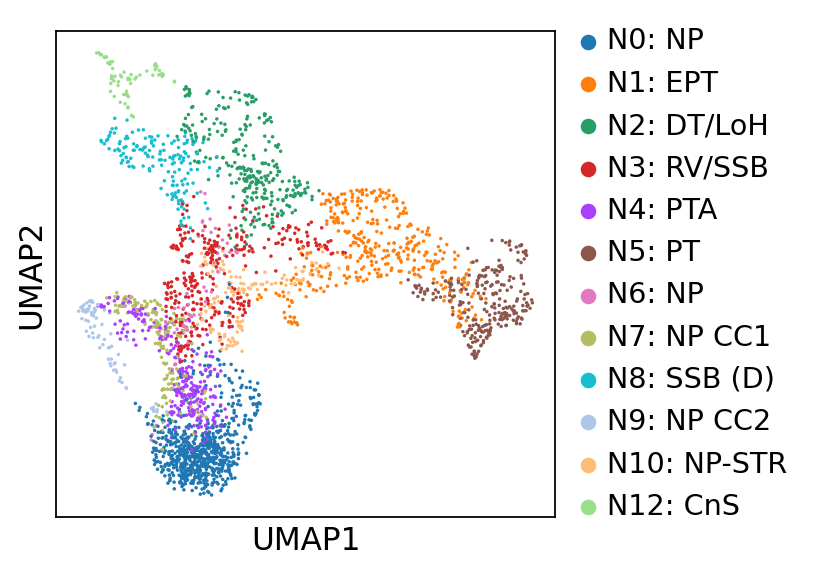

In [24]:
# we can map cell types onto Leiden clusters based on the cell type score from cell_type_df
cell_type_dict = {}
for i in cell_type_df.columns:
    cell_type_dict[i] = cell_type_df[i].idxmax()

# Add paper_nephron_labels as our nephron cell type annotation in nephron_adata.obs
nephron_adata.obs['paper_nephron_labels'] = nephron_adata.obs['leiden'].replace(cell_type_dict)

sc.pl.umap(nephron_adata, color='paper_nephron_labels', title="", size=10, save = '_paper_nephron_labels.png')

We can view other dimensionality reductions of the nephron dataset to see which is best for pseudotime analysis.

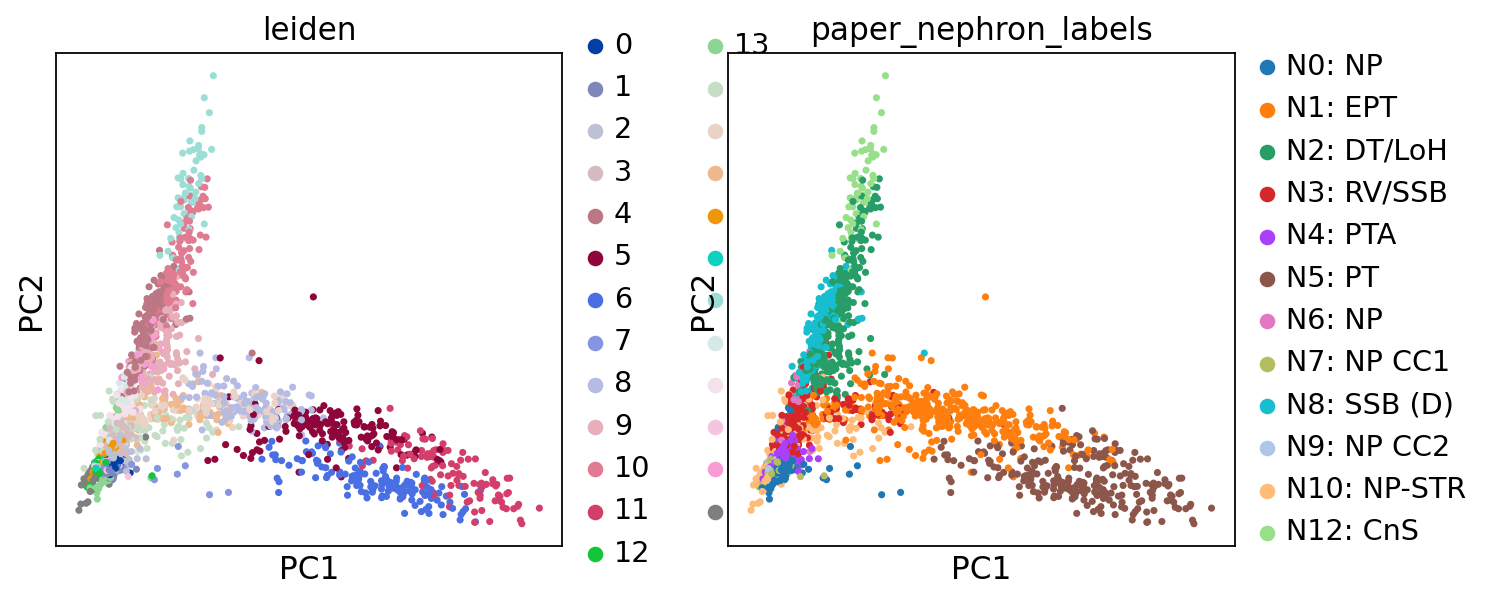

In [25]:
sc.pl.pca_scatter(nephron_adata, color=['leiden', 'paper_nephron_labels'])

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:16)


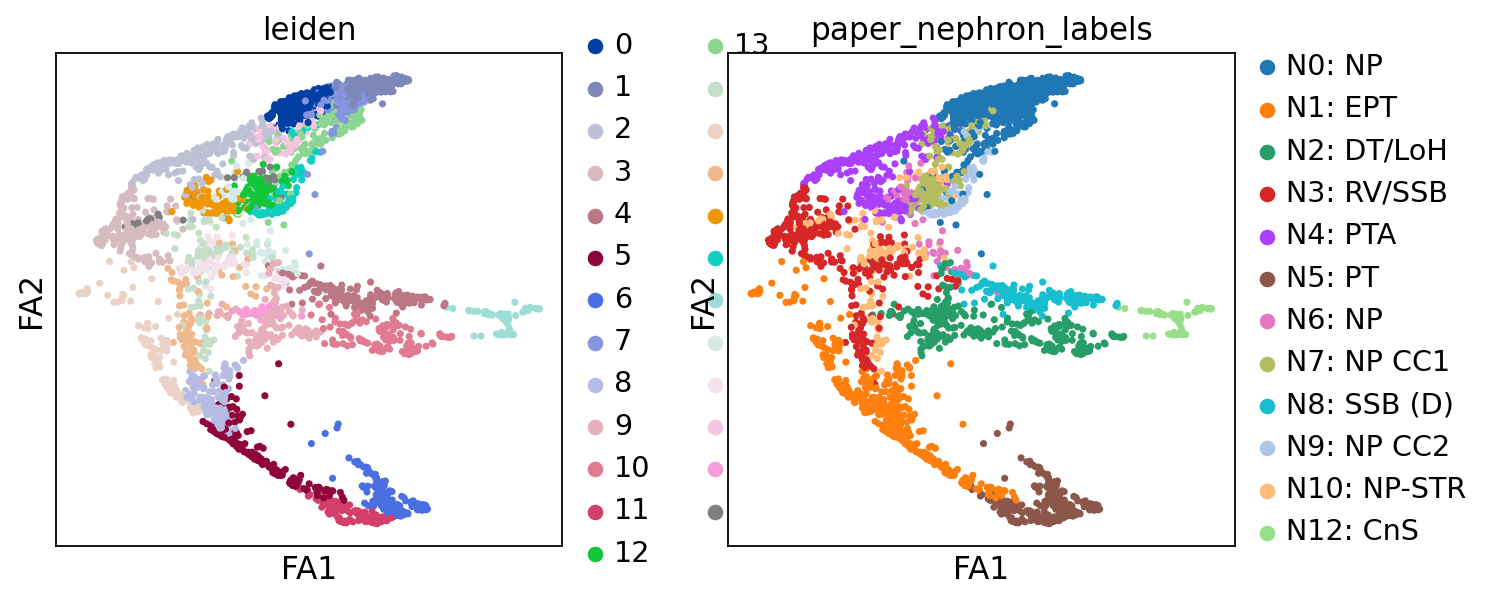

In [26]:
sc.tl.draw_graph(nephron_adata)
sc.pl.draw_graph(nephron_adata, color=['leiden', 'paper_nephron_labels'])

### Pseudotime Trajectory Analysis <a class="anchor" id="12-bullet"></a>

In [27]:
# anndata2ri for some reason cannot pass the neighbors attribute into the SCE object so 
# we need to delete this attribute. I posted about this and it will be added to the next update.

nephron_sce = nephron_adata.copy()

del nephron_sce.uns['neighbors']

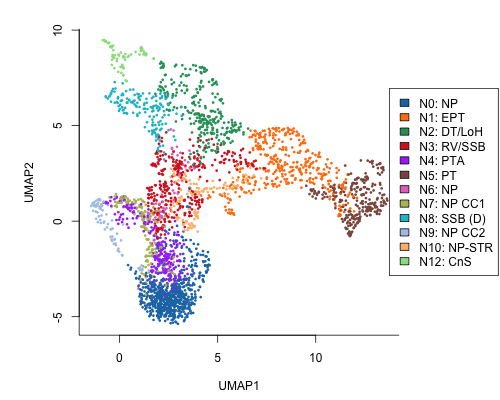

In [28]:
%%R -i nephron_sce -w 500 -h 400

# -i nephron_sce passes in the nephron_sce AnnData object & converts to sce object
# -w 500 -h 400 sets plot dimensions

# We can plot the UMAP coordinates in R.

par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(nephron_sce)$UMAP[,1], 
     reducedDims(nephron_sce)$UMAP[,2], 
     col=unlist(metadata(nephron_sce)$paper_nephron_labels_colors)[colData(nephron_sce)$paper_nephron_labels], 
     bty='L', xlab='UMAP1', ylab='UMAP2', pch=16, cex=0.5)
legend("right", inset=c(-0.31,0), legend=sort(unique(colData(nephron_sce)$paper_nephron_labels)), 
       fill=unlist(metadata(nephron_sce)$paper_nephron_labels_colors))

We can do pseudotime trajectory analysis on our nephron cells. In their paper, Combes et al. specify N0: NP as their root cluster, and have two endpoints, N5: PT and N12: CnS. 

In [29]:
%%time
%%R -i nephron_sce
print("1:")

nephron_sling <- slingshot(nephron_sce, 
                           clusterLabels = 'paper_nephron_labels', 
                           reducedDim = 'UMAP',
                          start.clus=c('N0: NP'),
                          end.clus=c('N5: PT', 'N12: CnS'))

print(SlingshotDataSet(nephron_sling))

[1] "1:"
class: SlingshotDataSet 

 Samples Dimensions
    2925          3

lineages: 3 
Lineage1: N0: NP  N7: NP CC1  N4: PTA  N6: NP  N10: NP-STR  N3: RV/SSB  N1: EPT  N5: PT  
Lineage2: N0: NP  N7: NP CC1  N4: PTA  N6: NP  N2: DT/LoH  N8: SSB (D)  N12: CnS  
Lineage3: N0: NP  N7: NP CC1  N9: NP CC2  

curves: 3 
Curve1: Length: 22.233	Samples: 2043.42
Curve2: Length: 20.057	Samples: 1645.41
Curve3: Length: 10.83	Samples: 983.39
CPU times: user 25 s, sys: 397 ms, total: 25.4 s
Wall time: 24.5 s


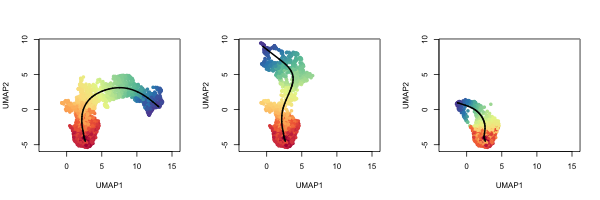

In [30]:
%%R -w 600 -h 200

par(mfrow=c(1,3))

#Plot of lineage 1
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(nephron_sling)$UMAP[,c(1,2)], col = colors[cut(nephron_sling$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='UMAP1', ylab='UMAP2')
lines(slingCurves(nephron_sling)$curve1, lwd=2)

#Plot of lineage 2
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(nephron_sling)$UMAP[,c(1,2)], col = colors[cut(nephron_sling$slingPseudotime_2,breaks=100)], pch=16, asp = 1, xlab='UMAP1', ylab='UMAP2')
lines(slingCurves(nephron_sling)$curve2, lwd=2)

#Plot of lineage 3
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plot(reducedDims(nephron_sling)$UMAP[,c(1,2)], col = colors[cut(nephron_sling$slingPseudotime_3,breaks=100)], pch=16, asp = 1, xlab='UMAP1', ylab='UMAP2')
lines(slingCurves(nephron_sling)$curve3, lwd=2)

We get three trajectories from our nephron dataset. Combes et al. only get two trajectories, but they write there is a renewing nephron progenitor population corresponding to the third trajectory (curve3). We can add them onto the Scanpy skin object to save.

In [31]:
%%R -o pt_df,traj1,traj2,traj3

# We could just pass our nephron_sling object as output from our R cell and make it a
# sce object with anndata2ri, but it's nice to have all our annotations on one object.

# We can save the pseudotime values
pt_df <- as.data.frame(slingPseudotime(nephron_sling, na=False))

# We can save the curve coordinates of the trajectories (for easy plotting with scanpy!)
traj <- slingCurves(nephron_sling)
traj1 <- traj$curve1$s
traj2 <- traj$curve2$s
traj3 <- traj$curve3$s

In [32]:
# Add the pseudotime values as obs annotations to our scanpy object
nephron_adata.obs['slingPseudotime_1'] = pt_df['curve1']
nephron_adata.obs['slingPseudotime_2'] = pt_df['curve2']
nephron_adata.obs['slingPseudotime_3'] = pt_df['curve3']

# Add the curve coordinates to the scanpy object.
nephron_adata.obsm['curve1'] = traj1
nephron_adata.obsm['curve2'] = traj2
nephron_adata.obsm['curve3'] = traj3

### Pathway States Analysis <a class="anchor" id="13-bullet"></a>

We can now plot the average gene expression for leiden clusters within the skin subset of the nephron dataset. We can apply a simple cosine metric to cluster this data to check by eye whether there are distinct pathway states here.

In [33]:
ticker = pn.widgets.Select(name='Pathway', options=list(pathways.keys()), width=150)
int_slider = pn.widgets.IntSlider(name='Number of Pathway Clusters', 
                                  start = 2, end=len(nephron_adata.obs['leiden'].unique())-1,
                                 width=250)

@pn.depends(ticker.param.value)

def get_silhouette(ticker_val):
    genes = pathways[ticker_val]
    fig = md.silhouette_plots(nephron_adata, ticker_val, genes)[0]
    fig.set_size_inches(4,4)
    plt.close()
    return fig

@pn.depends(ticker.param.value, int_slider.param.value)

def get_heatmap(ticker_val, slider_val): 
    genes = pathways[ticker_val]
    g = md.heatmap(nephron_adata, genes, slider_val, ticker_val, norm=True, figsize=(10,8))[0]
    plt.close()
    return g

@pn.depends(ticker.param.value, int_slider.param.value)

def get_umap(ticker_val, slider_val):
    fig = Figure()
    fig.set_size_inches(4,4)
    ax = fig.subplots()
    FigureCanvasBase(fig)
    sc.pl.umap(nephron_adata, color = ticker_val, ax=ax, show=True, size = 20)
    ax.legend()
    ax.set_title(ticker_val)
    return fig

row1 = pn.Column(ticker, int_slider,align='center')
row3 = pn.Column(row1, pn.Spacer(height=10),get_heatmap,align='center')
col1 = pn.Column(get_silhouette, get_umap, align='center')
row2 = pn.Row(col1, row3, align='center')

col=pn.Column(row2, align='center')

panel_layout = pn.Column(pn.pane.Markdown("##Pathway Clusters", align="center", 
                                          style={'font-family': 'Calibri (Body)'}), 
                         pn.pane.Markdown("You can select which patwhay \
                         to analyze, and select an ideal number of clusters based on silhouette scores. \
                         It takes a few seconds for this applet to update, so please be patient after updating \
                        the pathway clickbox or the slider for the cluster number.",
                                          align="center", 
                                          style={'font-family': 'Calibri (Body)'}),
                         col)
panel_layout.app();

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
... storing 'Wnt Ligands' as categorical


... storing 'Wnt Ligands' as categorical
... storing 'Wnt Ligands' as categorical
... storing 'Wnt Receptors' as categorical
... storing 'Wnt Receptors' as categorical
... storing 'Wnt Receptors' as categorical
... storing 'BMP Ligands' as categorical
... storing 'BMP Ligands' as categorical
... storing 'BMP Ligands' as categorical
... storing 'BMP Ligands' as categorical
... storing 'BMP Receptors' as categorical
... storing 'BMP Receptors' as categorical
... storing 'BMP Receptors' as categorical
... storing 'Notch' as categorical
... storing 'Notch' as categorical
... storing 'Notch' as categorical


The simple cosine clustering indicates there are pathway states, but as we can see from the heatmaps, gene expression data is noisy, and our clusters are not well defined. We can define a different distance metric (we use cosine here) that allows us to more accurately cluster noisy gene expression data. 

### Differential Gene Expression Test <a class="anchor" id="14-bullet"></a>

We can account for the noise in our gene expression data by performing a differential gene expression test that allows us to determine which genes are significantly differently expressed between two clusters. 

Specifically, we can define a distance metric for our clustering: for n genes expressed in clusters *x* and *y*, the distance is defined as

$$d_{i,j} = \frac{\sum_{i=1}^{n} w_ix_iy_i}{{\sum_{i=1}^{n} x_i^2}{\sum_{i=1}^{n} y_i^2}},$$
where x and y are $n \times 1$ vectors of gene expression, and $w$ is a $n \times 1$ weight vector of differential expression of the n genes between vectors x and y, where
$w_i =
  \begin{cases}
    1 &\text{if } p_i < 10^{-2}\\\\
    0 &\text{otherwise}
  \end{cases}
$

First, we need to do our differential gene expression test for differntially expressed genes between all pairs of Leiden clusters. We use the R package DE Single for this.

Note that DE Single takes as input gene matrix data that has not been normalized, as is convention for DGE testing.

In [34]:
# The pre_norm AnnData object stores our data prior to normalization. We can make a df 
# of the counts for the subset of skin cells.
count_df = pd.DataFrame(pre_norm[nephron_adata.obs.index, 
                                     nephron_adata.var.index].X,
                       index = nephron_adata.obs.index,
                       columns=nephron_adata.var.index)

# The SCE class in R stores gene expression data in a matrix where rows are genes and
# columns are cells, so we need to transpose our above df.
count_df = count_df.T # sce object stores genes in rows and cells in columns, so need transpose

Below is the code for our differential gene expression testing with DE Single. It takes several hours to run. We can run the code directly in our Jupyter notebook, either directly executed in the cell or as a script. We can also open up the script in R on our terminal (which avoids the possibility of JupyterLab crashing). 

In [35]:
%%R -i count_df

# Exporting data for DGE analysis with DESingle
print(dim(count_df))

# Add the count data before the normalization as an annotation to the slingshot output
# SCE object. 
count_mtx <- as.matrix(count_df)
counts(nephron_sce) <- count_mtx
logcounts(nephron_sce) <- log10(count_mtx+1)

saveRDS(nephron_sce, file = "./e18.5_kidney/results/nephron_sce.rds")

[1] 2493 2925


In [ ]:
%%time
%%R

# Option 1: run an R script with the differential gene expression test
# source("./e18.5_kidney/results/dge_test.R") # uncomment the code
# Option 0: Best option -- avoids Jupyter Notebook crash -- run the above script in R via commandline.

# Option 2: Run directly into the Jupyter notebook

library(DEsingle)
library(BiocParallel) # for Parallel computing
library(iterators) # to make combinations
library(parallel)

# parallelizes the operations
BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers <- parallel::detectCores() - 1
BPPARAM$progressbar <- TRUE

# computes all pairwise combinations of leiden clusters, i.e. n leiden clusters leads to n choose 2 combs.
combos <- combn(unique(colData(nephron_sce)[9]$leiden), m=2, simplify=FALSE)

# doing the differential expression test
for (val in seq_along(combos))
{
  cat(val,"out of",length(combos),"\n")
  mtx1 <- count_mtx[,colData(nephron_sce)[9]$leiden == combos[[val]][1]] # count matrix for leiden cluster a
  mtx2 <- count_mtx[,colData(nephron_sce)[9]$leiden == combos[[val]][2]] # count matrix for leiden cluster b
  group <- factor(c(rep(combos[[val]][1],dim(mtx1)[2]), rep(combos[[val]][2],dim(mtx2)[2]))) # add "group" labels to our 2 count matrices
  fin_mtx <- cbind(mtx1, mtx2) # combine the two gene expression matrices we're comaring
  temp_results <- DEsingle(counts=fin_mtx,group=group, parallel=TRUE, BPPARAM=BPPARAM) # do the test
  write.csv(temp_results, paste0("./e18.5_kidney/results/DE_single_results/",combos[[val]][1],"_",combos[[val]][2], ".csv")) # replace with appropriate results directory
}

We can set a cut-off for significance for our differential expression test results. You can play around with the p-value cut-off for significance, and even the genes we use in our clustering, since some low expression genes with a lot of noise can impact our clustering.

In [36]:
pvalue = 1e-2

In [37]:
# Import the DE Single results
files = glob.glob(resdir+'DE_single_results/*.csv') #format the directories as necessary
prefix_to_drop = resdir+"DE_single_results/"

# We need to format our differential gene expression results
# For each pathway of genes, we can make a upper triangular dataframe that stores the weight matrix w 
# for each pairwise combination of Leiden clusters.

leiden_list = list(nephron_adata.obs['leiden'].unique())
leiden_list.sort()

# the dictionary that contains the dataframes for each pathway of genes
pathways_p_vals = dict([(key, pd.DataFrame(object,columns=leiden_list,
                                          index=leiden_list)) for
                       key in list(pathways.keys())])

for file_name in files:
    split_filename1 = file_name.split(prefix_to_drop)
    split_filename2 = split_filename1[1].split("_")
    first_leiden = split_filename2[0]
    second_leiden = split_filename2[1].split(".csv")[0]
    file = pd.read_csv(file_name, index_col=[0])
    count=0
    for gene_list in pathways_p_vals.keys():
        temp = list(file.loc[file.index.isin(pathways[gene_list])][file.loc[file.index.isin(pathways[gene_list])]["pvalue.adj.FDR"] < pvalue]["pvalue.adj.FDR"].index)
        weight_vector = []
        for idx, item in enumerate(pathways[gene_list]):
            if item in temp:
                weight_vector.append(1.0)
            else:
                weight_vector.append(0.0)
        if (int(first_leiden) < int(second_leiden)):
            pathways_p_vals[gene_list].loc[first_leiden][second_leiden] = weight_vector
        else:
            pathways_p_vals[gene_list].loc[second_leiden][first_leiden] = weight_vector

In [38]:
ticker = pn.widgets.Select(name='Pathway', options=list(pathways.keys()), width=150)
int_slider = pn.widgets.IntSlider(name='Number of Pathway Clusters', 
                                  start = 2, end=len(nephron_adata.obs['leiden'].unique())-1,
                                 width=250)
@pn.depends(ticker.param.value)

def get_silhouette(ticker_val):
    genes = pathways[ticker_val]
    pval_df = pathways_p_vals[ticker_val]
    fig = md.weighted_silhouette_plot(nephron_adata, ticker_val, genes, pval_df)[0]
    fig.set_size_inches(4,4)
    plt.close()
    return fig

@pn.depends(ticker.param.value, int_slider.param.value)

def get_heatmap(ticker_val, slider_val): 
    genes = pathways[ticker_val]
    pval_df = pathways_p_vals[ticker_val]
    g = md.weighted_heatmap(nephron_adata, genes, pval_df, slider_val, ticker_val + " " + str(pvalue), norm=True, figsize=(10,8))[0]
    plt.close()
    return g

@pn.depends(ticker.param.value, int_slider.param.value)

def get_umap(ticker_val, slider_val):
    fig = Figure()
    fig.set_size_inches(4,4)
    ax = fig.subplots()
    FigureCanvasBase(fig)
    sc.pl.umap(nephron_adata, color = ticker_val, ax=ax, show=True, size = 20)
    ax.legend()
    ax.set_title(ticker_val)
    return fig

row1 = pn.Column(ticker, int_slider,align='center')
row3 = pn.Column(row1, pn.Spacer(height=10),get_heatmap,align='center')
col1 = pn.Column(get_silhouette, get_umap, align='center')
row2 = pn.Row(col1, row3, align='center')

col=pn.Column(row2, align='center')

panel_layout = pn.Column(pn.pane.Markdown("##Pathway Clusters", align="center", 
                                          style={'font-family': 'Calibri (Body)'}), 
                         pn.pane.Markdown("We can apply a simple Cosine metric to just check by eye whether \
                         there are distinct pathway states in the nephron_adata dataset. \n You can select which patwhay \
                         to analyze, and select an ideal number of clusters based on silhouette scores. \
                         It takes a few seconds for this applet to update, so please be patient after updating \
                        the pathway clickbox or the slider for the cluster number.",
                                          align="center", 
                                          style={'font-family': 'Calibri (Body)'}),
                         col)
panel_layout.app();

... storing 'Wnt Ligands 0.01' as categorical


... storing 'Wnt Ligands 0.01' as categorical
... storing 'Wnt Receptors 0.01' as categorical


For example, we can note that the BMP Receptor gene expression data is generally noisy, with low-expressed genes so we may eliminate some from our analysis.

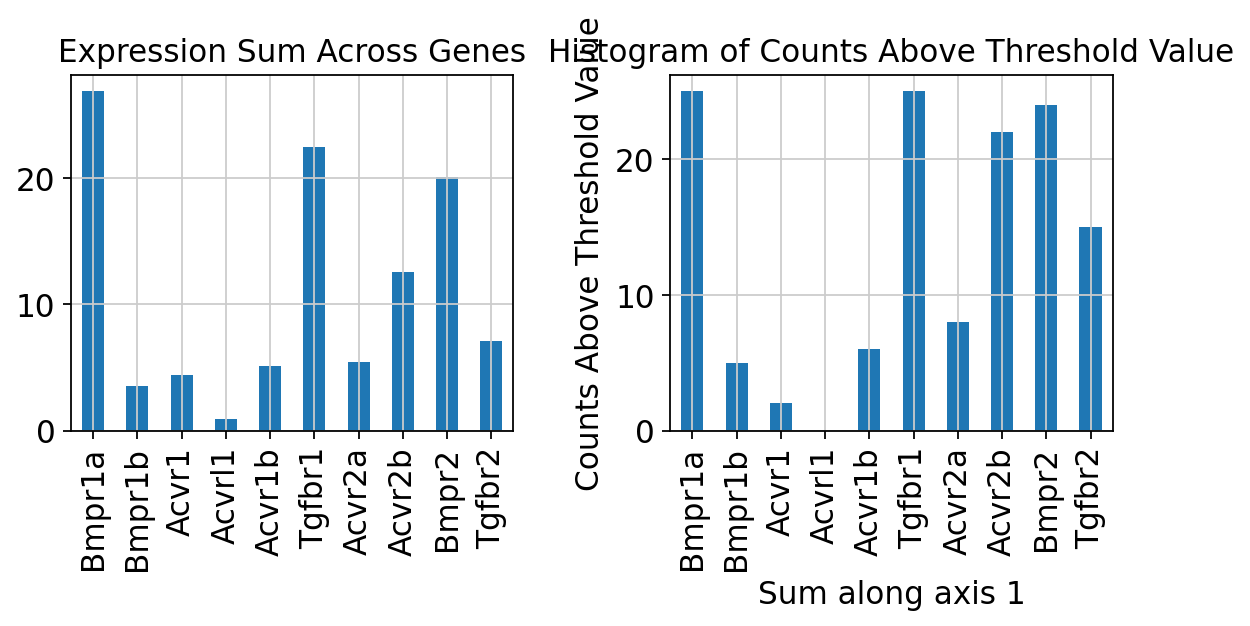

In [39]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
bmpr_df = md.gene_expression_norm(nephron_adata, pathways["BMP Receptors"])
md.exp_across_genes(bmpr_df, ax=ax[0])
md.exp_above_threshold(bmpr_df,1,0.25, fig_ax=ax[1]) # threshold value of 0.25 normalized counts
fig.set_tight_layout(True)

Bmpr1b, Acvr1, Acvrl1,Acvr1b,Acvr2a, and Tgfbr2 generally have low expression, so we can eliminate them from our analysis and proceed.

In [40]:
# Import the DE Single results

pathways["BMP Receptors"] = ["Bmpr1a", "Tgfbr1", "Acvr2b", "Bmpr2"]
files = glob.glob(resdir+'DE_single_results/*.csv') #format the directories as necessary
prefix_to_drop = resdir+"DE_single_results/"

# We need to format our differential gene expression results
# For each pathway of genes, we can make a upper triangular dataframe that stores the weight vector w 
# for each pairwise combination of Leiden clusters.

leiden_list = list(nephron_adata.obs['leiden'].unique())
leiden_list.sort()

# the dictionary that contains the dataframes for each pathway of genes
pathways_p_vals = dict([(key, pd.DataFrame(object,columns=leiden_list,
                                          index=leiden_list)) for
                       key in list(pathways.keys())])

for file_name in files:
    split_filename1 = file_name.split(prefix_to_drop)
    split_filename2 = split_filename1[1].split("_")
    first_leiden = split_filename2[0]
    second_leiden = split_filename2[1].split(".csv")[0]
    file = pd.read_csv(file_name, index_col=[0])
    count=0
    for gene_list in pathways_p_vals.keys():
        temp = list(file.loc[file.index.isin(pathways[gene_list])][file.loc[file.index.isin(pathways[gene_list])]["pvalue.adj.FDR"] < pvalue]["pvalue.adj.FDR"].index)
        weight_vector = []
        for idx, item in enumerate(pathways[gene_list]):
            if item in temp:
                weight_vector.append(1.0)
            else:
                weight_vector.append(0.0)
        if (int(first_leiden) < int(second_leiden)):
            pathways_p_vals[gene_list].loc[first_leiden][second_leiden] = weight_vector
        else:
            pathways_p_vals[gene_list].loc[second_leiden][first_leiden] = weight_vector

In [41]:
ticker = pn.widgets.Select(name='Pathway', options=["BMP Receptors"], width=150)
int_slider = pn.widgets.IntSlider(name='Number of Pathway Clusters', 
                                  start = 2, end=len(nephron_adata.obs['leiden'].unique())-1,
                                 width=250)
@pn.depends(ticker.param.value)

def get_silhouette(ticker_val):
    genes = pathways[ticker_val]
    pval_df = pathways_p_vals[ticker_val]
    fig = md.weighted_silhouette_plot(nephron_adata, ticker_val, genes, pval_df)[0]
    fig.set_size_inches(4,4)
    plt.close()
    return fig

@pn.depends(ticker.param.value, int_slider.param.value)

def get_heatmap(ticker_val, slider_val): 
    genes = pathways[ticker_val]
    pval_df = pathways_p_vals[ticker_val]
    g = md.weighted_heatmap(nephron_adata, genes, pval_df, slider_val, ticker_val + " " + str(pvalue), norm=True, figsize=(10,8))[0]
    plt.close()
    return g

@pn.depends(ticker.param.value, int_slider.param.value)

def get_umap(ticker_val, slider_val):
    fig = Figure()
    fig.set_size_inches(4,4)
    ax = fig.subplots()
    FigureCanvasBase(fig)
    sc.pl.umap(nephron_adata, color = ticker_val, ax=ax, show=True, size = 20)
    ax.legend()
    ax.set_title(ticker_val)
    return fig

row1 = pn.Column(ticker, int_slider,align='center')
row3 = pn.Column(row1, pn.Spacer(height=10),get_heatmap,align='center')
col1 = pn.Column(get_silhouette, get_umap, align='center')
row2 = pn.Row(col1, row3, align='center')

col=pn.Column(row2, align='center')

panel_layout = pn.Column(pn.pane.Markdown("##Pathway Clusters", align="center", 
                                          style={'font-family': 'Calibri (Body)'}), 
                         pn.pane.Markdown("We can apply a simple Cosine metric to just check by eye whether \
                         there are distinct pathway states in the nephron_adata dataset. \n You can select which patwhay \
                         to analyze, and select an ideal number of clusters based on silhouette scores. \
                         It takes a few seconds for this applet to update, so please be patient after updating \
                        the pathway clickbox or the slider for the cluster number.",
                                          align="center", 
                                          style={'font-family': 'Calibri (Body)'}),
                         col)
panel_layout.app();

... storing 'BMP Receptors 0.01' as categorical


... storing 'BMP Receptors 0.01' as categorical


Reducing the number of low expression clusters reveals that there are clearly fewer pathway states for BMP Receptors.

## Conclusion

We can save all our AnnData objects.

In [43]:
# Save the whole forelimb AnnData objects
del nephron_adata.obs[False] # get an error if I don't do this
nephron_adata.write_h5ad(resdir+"nephron_adata.h5ad")
pre_norm.write_h5ad(resdir+"pre_norm.h5ad")